# Appendix - Knowledge Graph and Deep Learning Python Code

## 1) Knowledge Graphs

Let's leverage the reviews of the movie "Sisters" in our corpus to generate knowledge graphs that can visualize relationships between named entities in the text.

### 1.1) Loading the Corpus

First, let's load the corpus into Python.

In [ ]:
# !pip install -U pip setuptools wheel
# !pip install -U spacy

In [2]:
 conda install -c conda-forge g2p-en


Note: you may need to restart the kernel to use updated packages.


In [3]:
# from g2p_en import G2p

ModuleNotFoundError: No module named 'g2p_en'

In [5]:
# !pip install tensorflow_datasets

  Using cached tensorflow_datasets-4.9.2-py3-none-any.whl (5.4 MB)
  Obtaining dependency information for array-record from https://files.pythonhosted.org/packages/4b/93/2a07d2f7317ea17ea9e17865d27175db13292ca8496aaeb6b9614aabe638/array_record-0.4.0-py39-none-any.whl.metadata
  Using cached dm_tree-0.1.8-cp39-cp39-win_amd64.whl (101 kB)
  Obtaining dependency information for etils[enp,epath]>=0.9.0 from https://files.pythonhosted.org/packages/4a/6a/d58ec120f5e4babbf5001c144266ba623dcdae8e81dc6cdb422a98d0e0ce/etils-1.4.1-py3-none-any.whl.metadata
  Using cached promise-2.3-py3-none-any.whl
  Using cached tensorflow_metadata-1.13.1-py3-none-any.whl (28 kB)
  Obtaining dependency information for importlib_resources from https://files.pythonhosted.org/packages/29/d1/bed03eca30aa05aaf6e0873de091f9385c48705c4a607c2dfe3edbe543e8/importlib_resources-6.0.0-py3-none-any.whl.metadata
   ---------------------------------------- 3.0/3.0 MB 13.7 MB/s eta 0:00:00
   ----------------------------------

In [6]:
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from collections import Counter
from dataclasses import dataclass
from timeit import default_timer as timer

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize 

import gensim
from gensim.models import Word2Vec

import spacy
from spacy import displacy

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from IPython.display import display, HTML

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
tf.random.set_seed(2022)
import tensorflow.keras.backend as k

from typing import List, Callable, Dict, Tuple, Set

In [7]:
# Requires Restart of Runtime after Installation

!python -m spacy download en_core_web_lg -q

C:\Users\steve\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [8]:
nlp = spacy.load('en_core_web_lg')

In [9]:
# Only run this once, they will be downloaded.
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('omw-1.4',quiet=True)

True


Gensim is a Python library for topic modelling, document indexing and similarity retrieval with large corpora. Target audience is the natural language processing (NLP) and information retrieval (IR) community: https://pypi.org/project/gensim/ 

In [10]:
import pkg_resources
#pkg_resources.require("gensim<=3.8.3");

In [11]:
print("Genism Version: ", gensim.__version__)

Genism Version:  4.1.2


In [12]:
# Suppress Warning Messages
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [15]:
def add_movie_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    """
    Adds "Movie Description" to the supplied dataframe, in the form {Genre}_{P|N}_{Movie Title}_{DocID}
    """
    review = np.where(corpus_df['Review Type (pos or neg)'] == 'Positive', 'P', 'N')
    data['Descriptor'] = corpus_df['Genre of Movie'] + '_' + corpus_df['Movie Title'] + '_' + review + '_' + corpus_df['Doc_ID'].astype(str)

def get_corpus_df(path: str) -> pd.DataFrame:
    data = pd.read_csv(path,encoding="utf-8")
    add_movie_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['Doc_ID'])
    indexed_data['Doc_ID'] = indexed_data.index
    return indexed_data

corpus_df = get_corpus_df('MSDS453_ClassCorpus_Final_Sec56_v5_20230720.csv')

### 1.2) Exploratory Data Analysis

Having loaded the appropriate Python libraries and loaded the corpus of movie reviews, let's conduct some initial exploratory data analysis.

In [17]:
# Tokenize sentences
def get_sentences(text: str) -> List[str]:
    return [str(x) for x in nlp(text).sents]

corpus_df['raw_sentences'] = corpus_df.Text.apply(get_sentences)
corpus_df.head(3).T



Doc_ID,101,102,103
DSI_Title,SAR_Doc1_Covenant,SAR_Doc2_Covenant,SAR_Doc3_Covenant
Submission File Name,SAR_Doc1_Covenant,SAR_Doc2_Covenant,SAR_Doc3_Covenant
Student Name,SAR,SAR,SAR
Genre of Movie,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Covenant,Covenant,Covenant
Text,Nearly two years after the American military w...,Have Guy Ritchie and Jake Gyllenhaal switched ...,Guy Ritchie's The Covenant notably marks the f...
Descriptor,Action_Covenant_N_101,Action_Covenant_N_102,Action_Covenant_N_103
Doc_ID,101,102,103
raw_sentences,[Nearly two years after the American military ...,[Have Guy Ritchie and Jake Gyllenhaal switched...,[Guy Ritchie's The Covenant notably marks the ...


In [18]:
corpus_df.shape

(190, 10)

In [19]:
print(corpus_df.info());

<class 'pandas.core.frame.DataFrame'>
Int64Index: 190 entries, 101 to 217
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   DSI_Title                 190 non-null    object
 1   Submission File Name      190 non-null    object
 2   Student Name              190 non-null    object
 3   Genre of Movie            190 non-null    object
 4   Review Type (pos or neg)  190 non-null    object
 5   Movie Title               190 non-null    object
 6   Text                      190 non-null    object
 7   Descriptor                190 non-null    object
 8   Doc_ID                    190 non-null    int64 
 9   raw_sentences             190 non-null    object
dtypes: int64(1), object(9)
memory usage: 16.3+ KB
None


In [20]:
print(corpus_df['Movie Title'].unique())

['Covenant' 'Inception' 'No time to die' 'Taken' 'The Dark Knight Rises'
 'Despicable Me 3' 'Holmes and Watson' 'Legally Blonde' 'Lost City'
 'Sisters' 'Drag Me to Hell' 'Fresh' 'It Chapter Two' 'The Toxic Avenger'
 'US' 'Annihilation' 'Minority Report' 'Oblivion' 'Pitch Black']


In [21]:
corpus_df.columns

Index(['DSI_Title', 'Submission File Name', 'Student Name', 'Genre of Movie',
       'Review Type (pos or neg)', 'Movie Title', 'Text', 'Descriptor',
       'Doc_ID', 'raw_sentences'],
      dtype='object')

In [22]:
# Gather the number of reviews by genre
counts_df = corpus_df[['Genre of Movie']].copy()
counts_df['Count'] = 1
counts_df.groupby(['Genre of Movie']).count().reset_index()

,Genre of Movie,Count
0,Action,50
1,Comedy,50
2,Horror,50
3,Sci-Fi,40


### 1.3) Data Wrangling

Let's conduct data wrangling to prepare the text as needed prior to the creation of our knowledge graphs.

#### 1.3.1) Data Wrangling and Vectorization Method 1

Let's define data wrangling utility functions that we can leverage on our corpus.

In [23]:
def remove_punctuation(text: str) -> str:
    return re.sub('[^a-zA-Z]', '', str(text))

def remove_tags(text: str) -> str:    
    return re.sub('&lt;/?.*?&gt;', '', text)

def remove_special_chars_and_digits(text: str) -> str:
    return re.sub('(\\d|\\W)+', '', text)

def get_coref_resolved_sentences(text: str) -> List[str]:
    return [str(x) for x in nlp(text).sents]

def get_lemmas(text: str, stopwords: Set[str]) -> List[str]:
    initial = [remove_tags(remove_special_chars_and_digits(remove_punctuation(x.lemma_.lower()))) for x in nlp(text)]
    return [x for x in initial if x not in stopwords]

def lemmatize_sentence(text: str, stopwords: Set[str]) -> str:
    return ' '.join(get_lemmas(text, stopwords))

def clean_doc(doc): 
    #doc = remove_punctuation(doc)
    doc= ' '.join(remove_stop_words(doc))
    doc = apply_lemmatization(doc)
    return doc

def remove_stop_words(in_text):
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(in_text)  
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    return filtered_sentence

def apply_lemmatization(in_text):
    # Lemmatization
    lem = WordNetLemmatizer()
    word_list = nltk.word_tokenize(in_text)
    output = ' '.join([lem.lemmatize(w) for w in word_list])
    return output

def counter_word(text):
  count=Counter()
  for i in text.values:
    for word in i.split():
      count[word]=+1
  return count

Tokenize Words

In [24]:
default_stopwords=\
set(nltk.corpus.stopwords.words('english')).union(set(nlp.Defaults.stop_words)).union({' ', ''})
corpus_df['lemmas'] = corpus_df.Text.apply(lambda x: get_lemmas(x, default_stopwords))
corpus_df.lemmas.head()

Doc_ID
101    [nearly, year, american, military, withdraw, a...
102    [guy, ritchie, jake, gyllenhaal, switch, place...
103    [guy, ritchie, covenant, notably, mark, featur...
104    [weird, throwback, chuck, norris, miss, action...
105    [little, odd, guy, ritchie, come, title, guy, ...
Name: lemmas, dtype: object

In [25]:
corpus_df.head(3).T

Doc_ID,101,102,103
DSI_Title,SAR_Doc1_Covenant,SAR_Doc2_Covenant,SAR_Doc3_Covenant
Submission File Name,SAR_Doc1_Covenant,SAR_Doc2_Covenant,SAR_Doc3_Covenant
Student Name,SAR,SAR,SAR
Genre of Movie,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Covenant,Covenant,Covenant
Text,Nearly two years after the American military w...,Have Guy Ritchie and Jake Gyllenhaal switched ...,Guy Ritchie's The Covenant notably marks the f...
Descriptor,Action_Covenant_N_101,Action_Covenant_N_102,Action_Covenant_N_103
Doc_ID,101,102,103
raw_sentences,[Nearly two years after the American military ...,[Have Guy Ritchie and Jake Gyllenhaal switched...,[Guy Ritchie's The Covenant notably marks the ...


Reassemble Lemmatized Words

In [26]:
corpus_df['lemmas_joined'] = corpus_df.lemmas.apply(lambda x: ' '.join(x))

In [27]:
corpus_df['lemmas_joined'].head()

Doc_ID
101    nearly year american military withdraw afghani...
102    guy ritchie jake gyllenhaal switch place peter...
103    guy ritchie covenant notably mark feature incl...
104    weird throwback chuck norris miss action film ...
105    little odd guy ritchie come title guy ritchie ...
Name: lemmas_joined, dtype: object

In [28]:
corpus_df.head(3).T

Doc_ID,101,102,103
DSI_Title,SAR_Doc1_Covenant,SAR_Doc2_Covenant,SAR_Doc3_Covenant
Submission File Name,SAR_Doc1_Covenant,SAR_Doc2_Covenant,SAR_Doc3_Covenant
Student Name,SAR,SAR,SAR
Genre of Movie,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Covenant,Covenant,Covenant
Text,Nearly two years after the American military w...,Have Guy Ritchie and Jake Gyllenhaal switched ...,Guy Ritchie's The Covenant notably marks the f...
Descriptor,Action_Covenant_N_101,Action_Covenant_N_102,Action_Covenant_N_103
Doc_ID,101,102,103
raw_sentences,[Nearly two years after the American military ...,[Have Guy Ritchie and Jake Gyllenhaal switched...,[Guy Ritchie's The Covenant notably marks the ...


Vocabulary Data Wrangling

In [29]:
vectorizer = CountVectorizer(ngram_range=(1, 1))
transformed_documents = vectorizer.fit_transform(corpus_df.lemmas_joined)
doc_term_matrix = transformed_documents.todense()
doc_term_df = pd.DataFrame(doc_term_matrix, 
                           columns=vectorizer.get_feature_names_out(), 
                           index=corpus_df.Descriptor)
print(f'All Word Vocabulary size: {doc_term_df.shape[1]}')
all_words = set(doc_term_df.columns)

vectorizer = CountVectorizer(ngram_range=(1, 1), min_df=5, max_df=.8)
transformed_documents = vectorizer.fit_transform(corpus_df.lemmas_joined)
doc_term_matrix = transformed_documents.todense()
doc_term_df = pd.DataFrame(doc_term_matrix, 
                           columns=vectorizer.get_feature_names_out(), 
                           index=corpus_df.Descriptor)
print(f'Curated Vocabulary size: {doc_term_df.shape[1]}')
vocabulary = set(doc_term_df.columns)

words_to_remove = default_stopwords.union(all_words - vocabulary)

All Word Vocabulary size: 9247
Curated Vocabulary size: 2000


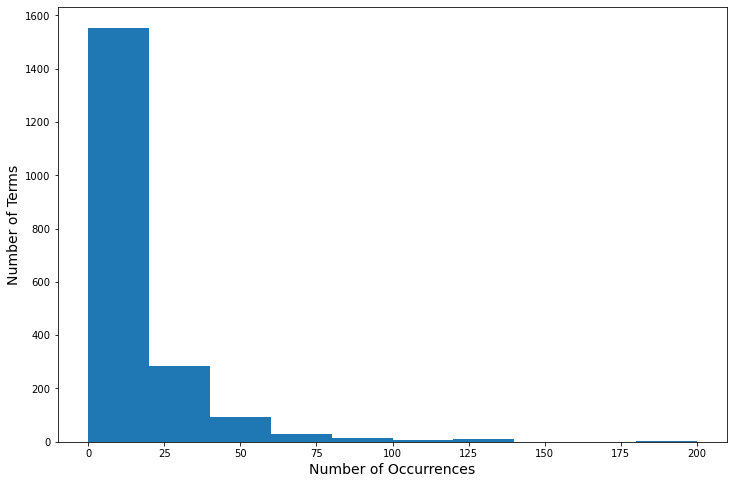

In [30]:
plt.figure(figsize = (12, 8))
plt.hist(doc_term_df.sum(axis=0).T, range=(0, 200))
plt.xlabel('Number of Occurrences',fontsize=14)
plt.ylabel('Number of Terms',fontsize=14);

In [31]:
# Re-tokenize words, recreate joined documents
corpus_df['lemmas'] = corpus_df.Text.apply(lambda x: get_lemmas(x, words_to_remove))
corpus_df['lemmas_joined'] = corpus_df.lemmas.apply(lambda x: ' '.join(x))
corpus_df.lemmas.head()

Doc_ID
101    [nearly, year, american, military, afghanistan...
102    [guy, ritchie, jake, gyllenhaal, switch, place...
103    [guy, ritchie, covenant, notably, mark, featur...
104    [weird, throwback, miss, action, guy, ritchie,...
105    [little, odd, guy, ritchie, come, title, guy, ...
Name: lemmas, dtype: object

Get Lemmatized and Filtered Sentences

In [32]:
corpus_df['sentences_lemmatized']=\
corpus_df.raw_sentences.apply(lambda x: [lemmatize_sentence(s, words_to_remove) for s in x])

In [33]:
corpus_df.head().T

Doc_ID,101,102,103,104,105
DSI_Title,SAR_Doc1_Covenant,SAR_Doc2_Covenant,SAR_Doc3_Covenant,SAR_Doc4_Covenant,SAR_Doc5_Covenant
Submission File Name,SAR_Doc1_Covenant,SAR_Doc2_Covenant,SAR_Doc3_Covenant,SAR_Doc4_Covenant,SAR_Doc5_Covenant
Student Name,SAR,SAR,SAR,SAR,SAR
Genre of Movie,Action,Action,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative,Negative,Negative
Movie Title,Covenant,Covenant,Covenant,Covenant,Covenant
Text,Nearly two years after the American military w...,Have Guy Ritchie and Jake Gyllenhaal switched ...,Guy Ritchie's The Covenant notably marks the f...,"In a weird throwback to those Chuck Norris ""Mi...",It's a little odd that Guy Ritchie's name come...
Descriptor,Action_Covenant_N_101,Action_Covenant_N_102,Action_Covenant_N_103,Action_Covenant_N_104,Action_Covenant_N_105
Doc_ID,101,102,103,104,105
raw_sentences,[Nearly two years after the American military ...,[Have Guy Ritchie and Jake Gyllenhaal switched...,[Guy Ritchie's The Covenant notably marks the ...,"[In a weird throwback to those Chuck Norris ""M...",[It's a little odd that Guy Ritchie's name com...


Review Documents By Movie Title

In [34]:
print(corpus_df['Movie Title'].unique())

['Covenant' 'Inception' 'No time to die' 'Taken' 'The Dark Knight Rises'
 'Despicable Me 3' 'Holmes and Watson' 'Legally Blonde' 'Lost City'
 'Sisters' 'Drag Me to Hell' 'Fresh' 'It Chapter Two' 'The Toxic Avenger'
 'US' 'Annihilation' 'Minority Report' 'Oblivion' 'Pitch Black']


In [35]:
movie_df = corpus_df[corpus_df['Movie Title'] == 'Sisters'].copy()
movie_df.head(3).T

Doc_ID,136,137,138
DSI_Title,SJD_Doc6_Sisters,SJD_Doc7_Sisters,SJD_Doc8_Sisters
Submission File Name,SJD_Doc6_Sisters,SJD_Doc7_Sisters,SJD_Doc8_Sisters
Student Name,SJD,SJD,SJD
Genre of Movie,Comedy,Comedy,Comedy
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Sisters,Sisters,Sisters
Text,Without its two leads (and some great supporti...,"The chemistry between these two ""Saturday Nigh...",Sisters plants the seeds of its own criticism ...
Descriptor,Comedy_Sisters_N_136,Comedy_Sisters_N_137,Comedy_Sisters_N_138
Doc_ID,136,137,138
raw_sentences,[Without its two leads (and some great support...,"[The chemistry between these two ""Saturday Nig...",[Sisters plants the seeds of its own criticism...


#### 1.3.2) Data Wrangling and Vectorization Method 2

#### 1.3.3) Data Wrangling and Vectorization Method 3

### 1.4) Knowledge Graphs

Let's define knowledge context graph functions.

In [36]:
def map_edges(map_to: str, map_from: Set[str], df: pd.DataFrame):
    print(f'Before mapping {", ".join(map_from)} -> {map_to}: {sum(df.edge == map_to)}')
    df['edge'] = np.where(kg_df.edge.isin(map_from), map_to, kg_df.edge)
    print(f'After mapping {", ".join(map_from)} -> {map_to}: {sum(df.edge == map_to)}')
    
def map_sources_and_targets(map_to: str, map_from: Set[str], df: pd.DataFrame):
    before = sum(df.source == map_to) + sum(df.target == map_to)
    print(f'Before mapping {", ".join(map_from)} -> {map_to}: {before}')
    
    df['source'] = np.where(kg_df.source.isin(map_from), map_to, kg_df.source)
    df['target'] = np.where(kg_df.target.isin(map_from), map_to, kg_df.target)
    
    after = sum(df.source == map_to) + sum(df.target == map_to)
    print(f'After mapping {", ".join(map_from)} -> {map_to}: {after}')
    
def get_neighborhood(sources: Set[str], edge_types: Set[str], depth: int, df: pd.DataFrame) -> pd.DataFrame:
    output = []
    
    for d in range(depth):
        if edge_types is not None:
            rows = df[(df.edge.isin(edge_types)) & ((df.source.isin(sources)) | (df.target.isin(sources)))].copy()
        else:
            rows = df[(df.source.isin(sources)) | (df.target.isin(sources))].copy()
            
        output.append(rows)
        sources = set(rows.target).union(set(rows.source))
        
    return pd.concat(output).drop_duplicates()

def find_sources_and_targets_with_patterns(patterns: List[str], df: pd.DataFrame):
    mask = np.zeros(kg_df.shape[0])
    for pattern in patterns:
        mask = mask | (df.source.str.contains(pattern)) | (df.target.str.contains(pattern))
        
    return df[mask]
# Examples of how to use the function:
# find_sources_and_targets_with_patterns(['action'], kg_df)
# find_sources_and_targets_with_patterns(['terror'], kg_df)
# find_sources_and_targets_with_patterns(['novel'], kg_df)
# find_sources_and_targets_with_patterns(['director', 'campbell'], kg_df)


def plot_graph(df: pd.DataFrame, show_edges: bool = False, figsize: Tuple[int, int] = (12, 12), use_circular: bool=True):
    graph = nx.from_pandas_edgelist(df, "source", "target", edge_attr='edge', create_using=nx.MultiDiGraph())

    plt.figure(figsize=figsize)
    if use_circular:
        pos = nx.circular_layout(graph)
    else:
        pos = nx.kamada_kawai_layout(graph)
        
    nx.draw(graph, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
    if show_edges:
        nx.draw_networkx_edge_labels(graph, pos=pos, font_size=8)
        
    plt.show()
    
def get_top_sources_and_targets(df: pd.DataFrame, top: int = 10):
    return (Counter(df.source) + Counter(df.target)).most_common(top)

def get_top_edges(df: pd.DataFrame, top: int = 10):
    return Counter(df.edge).most_common(top)

def get_dataset_partitions_pd(df, train_split=0.8, val_split=0.10, test_split=0.10):
       # Specify seed to always have the same split distribution between runs
    df_sample = df.sample(frac=1, random_state=12)
    indices_or_sections = [int(.8*len(df)), int(.9*len(df))]
    train_ds, val_ds, test_ds = np.split(df_sample, indices_or_sections)
    return train_ds, val_ds, test_ds

Let's define entity extraction functions.

In [37]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text

  return [ent1.strip(), ent2.strip()]

def get_relation(sent):
    try:
        doc = nlp(sent)
        
        # Matcher class object 
        matcher = Matcher(nlp.vocab)

        #define the pattern 
        pattern = [{'DEP':'ROOT'}, 
                {'DEP':'prep','OP':"?"},
                {'DEP':'agent','OP':"?"},  
                {'POS':'ADJ','OP':"?"}] 
        matcher.add("matching_1", [pattern]) 
        matches = matcher(doc)
        k = len(matches) - 1
        span = doc[matches[k][1]:matches[k][2]] 
        
        return(span.text)
    except:
        pass
    
def get_subject_verb_object(sent):
  ent1 = ""
  ent2 = ""
  root = ""

  for tok in nlp(sent):
      if tok.dep_ == 'ROOT':
        root = tok.text
      elif tok.dep_ == "nsubj":
        ent1 = tok.text
      elif tok.dep_ == "dobj":
        ent2 = tok.text

      if ent1 != '' and ent2 != '' and root != '':
        break

  return [ent1, root, ent2]

Knowledge Graph Extraction

In [38]:
corpus_text_sentences = [y for x in movie_df.raw_sentences for y in x]
example_sentence = nlp(corpus_text_sentences[5])
corpus_text_sentences[5]

"As with her Parks & Rec character, Poehler's Maura is an uptight forty-something do-gooder here."

In [39]:
entity_pairs = [get_entities(x) for x in tqdm(corpus_text_sentences)]

100%|███████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 133.95it/s]


In [40]:
entity_pairs

[['Sisters', 'gags'],
 ['it', 'genuine  stars'],
 ['likes', 'impressive Jenny indies'],
 ['we', 'running TV sitcoms'],
 ['far  Sisters', 'yet  talents'],
 ['Parks  Maura', 'Parks  character'],
 ['parents', 'home James sale'],
 ['older  who', 'financial  trouble'],
 ['in nostalgia duo', 'final teen years'],
 ['I', 'along  Fey'],
 ['days writer Paula I', 'one  liner'],
 ['more  Fey', 'Rock Girls shows'],
 ['likeable  charm', 'way  script'],
 ['that', 'two  hours'],
 ['extended party that', 'one Trading point'],
 ['us', 'her'],
 ['such cast sequences', 'cast list'],
 ['That', 'final  cut'],
 ['second  they', 'Night Live Night alumni'],
 ['also  what', 'unfocused  screenplay'],
 ['they', '2 hour joke'],
 ['material', 'strengths'],
 ['normal  everyone', 'cast'],
 ['', 'shoehorned character arcs'],
 ['teenage Madison who', 'teenage Madison Davenport'],
 ['suddenly childhood sisters', 'last  stuff'],
 ['Sisters', 'uncomfortable adult conversations'],
 ['single premise movie', 'energy'],
 ['wh

Create Dataframe of Sources, Edges, and Targets

In [41]:
relations = [get_relation(x) for x in corpus_text_sentences]   
#extract subject and object
source = [i[0] for i in entity_pairs]
target = [i[1] for i in entity_pairs]
kg_df = pd.DataFrame({'source': source, 'target': target, 'edge': relations})

Knowledge Graph Preprocessing (Lowercase Transformation and Removal of Empty Spaces)

In [42]:
# Move everything to lower case
kg_df.source = kg_df.source.str.lower()
kg_df.target = kg_df.target.str.lower()
kg_df.edge = kg_df.edge.str.lower()

# Filter out empties
kg_df = kg_df[kg_df.source != '']
kg_df = kg_df[kg_df.target != '']
kg_df = kg_df[kg_df.edge != ''].copy()

In [43]:
kg_df.head(6).T

,0,1,2,3,4,5
source,sisters,it,likes,we,far sisters,parks maura
target,gags,genuine stars,impressive jenny indies,running tv sitcoms,yet talents,parks character
edge,be,'s,risen to,have,failed,is


In [44]:
kg_df.shape

(179, 3)

In [45]:
len(corpus_text_sentences)

210

Plotting Knowledge Graph

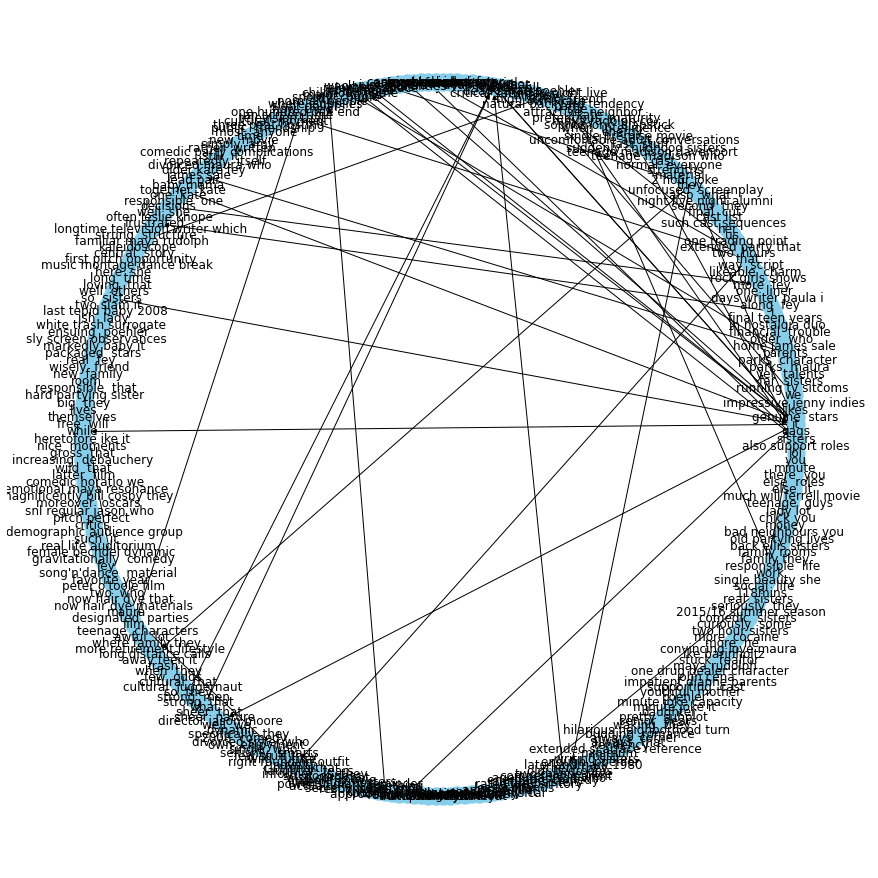

In [46]:
plot_graph(kg_df, use_circular=True)

Plotting Knowledge Graph Subset 1

Let's examine the subset of our knowledge graph connected to nodes that correspond to the movie title, "Sisters."

In [57]:
RELATION_TO_EXPLORE = 'sisters'

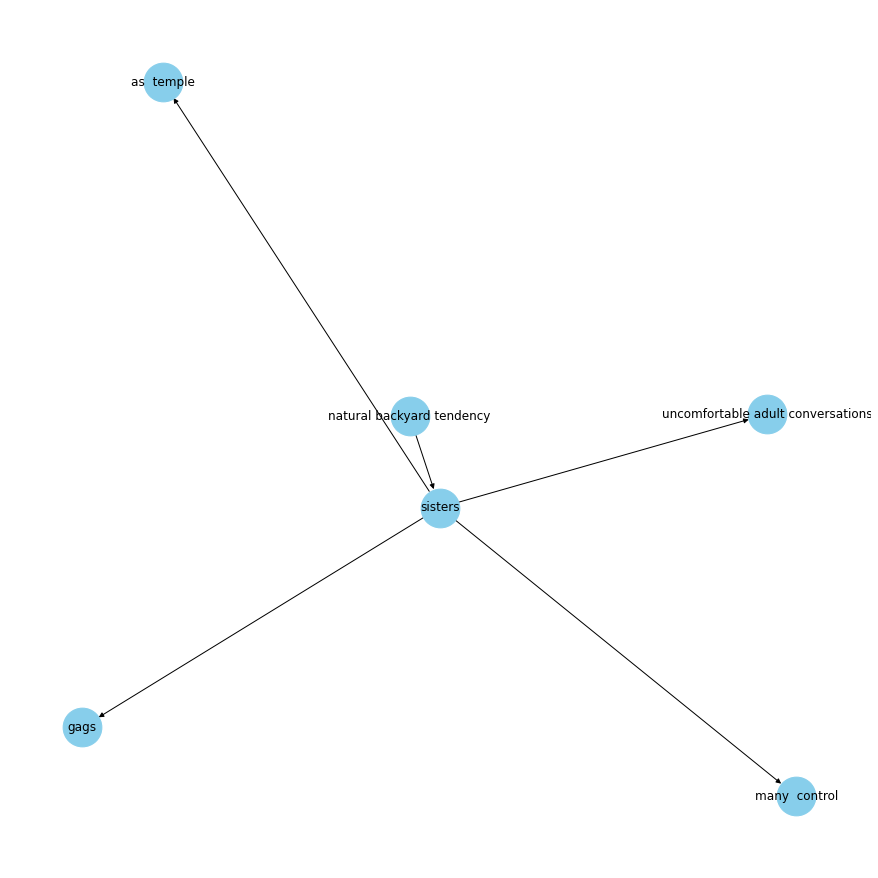

In [58]:
G = nx.from_pandas_edgelist(kg_df[(kg_df['source'] == RELATION_TO_EXPLORE) | (kg_df['target'] == RELATION_TO_EXPLORE) ], 
                            "source", "target", 
                            edge_attr=True, 
                            create_using=nx.MultiDiGraph())

plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G, k=0.5) # k regulates the distance between nodes

nx.draw(G, with_labels=True, 
        node_color='skyblue', 
        node_size=1500, edge_cmap=plt.cm.Blues, pos=pos)

plt.show()

Plotting Knowledge Graph Subset 2

Let's examine the subset of our knowledge graph connected to nodes that correspond to one of the lead actresses, Amy Poehler.

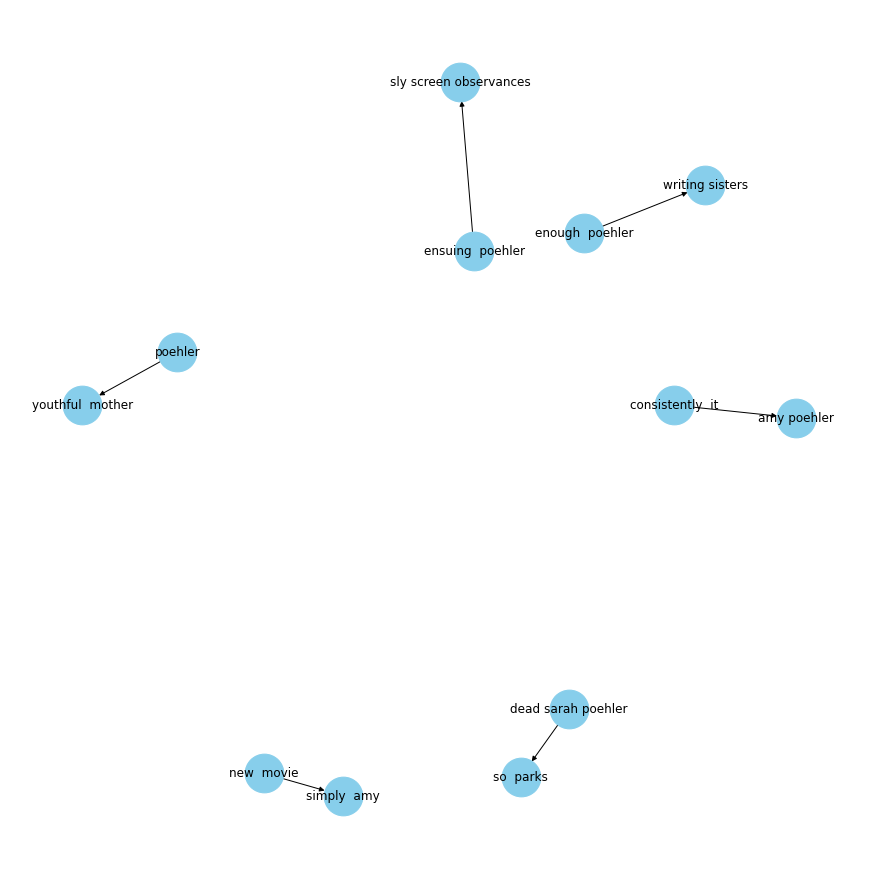

In [73]:
G = nx.from_pandas_edgelist(kg_df[(kg_df['source'].str.contains("amy") == True) | 
                                  (kg_df['target'].str.contains("amy") == True) | 
                                  (kg_df['source'].str.contains("poehler") == True) | 
                                  (kg_df['target'].str.contains("poehler") == True)  
                                  ], 
                            "source", "target", 
                            edge_attr=True, 
                            create_using=nx.MultiDiGraph())

plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G, k=0.5) # k regulates the distance between nodes

nx.draw(G, with_labels=True, 
        node_color='skyblue', 
        node_size=1500, edge_cmap=plt.cm.Blues, pos=pos)

plt.show()


Plotting Knowledge Graph Subset 3

Let's examine the subset of our knowledge graph connected to nodes that correspond to one of the lead actresses, Tina Fey.

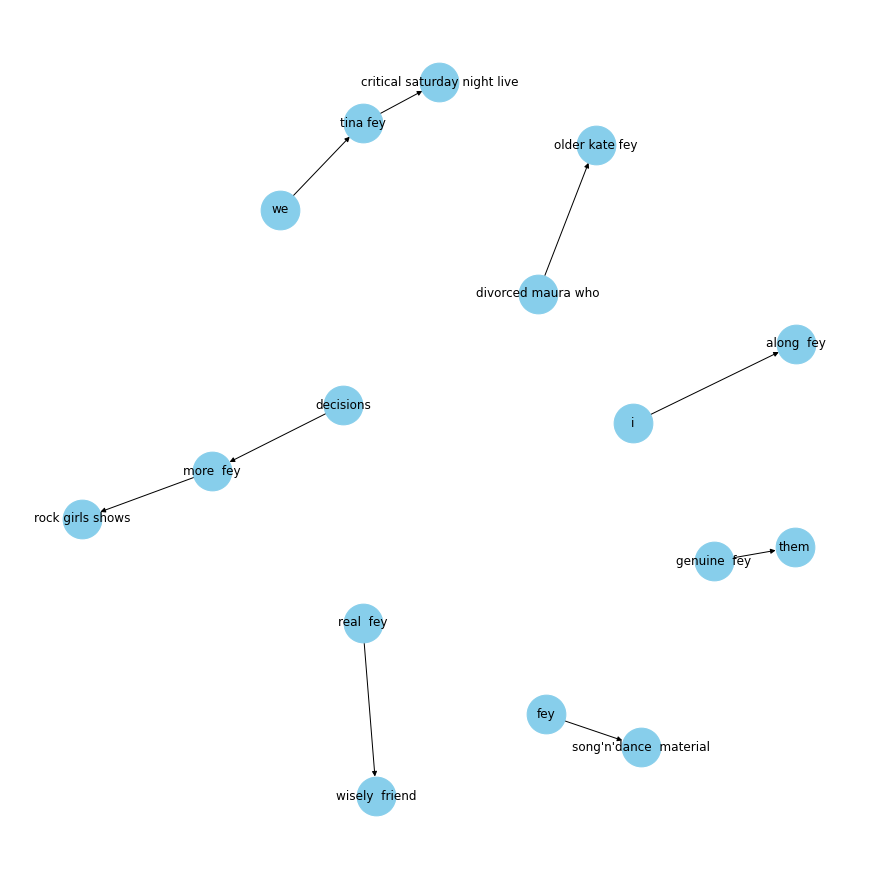

In [74]:
G = nx.from_pandas_edgelist(kg_df[(kg_df['source'].str.contains("tina") == True) | 
                                  (kg_df['target'].str.contains("tina") == True) | 
                                  (kg_df['source'].str.contains("fey") == True) | 
                                  (kg_df['target'].str.contains("fey") == True)  
                                  ], 
                            "source", "target", 
                            edge_attr=True, 
                            create_using=nx.MultiDiGraph())

plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G, k=0.5) # k regulates the distance between nodes

nx.draw(G, with_labels=True, 
        node_color='skyblue', 
        node_size=1500, edge_cmap=plt.cm.Blues, pos=pos)

plt.show()


## 2) Classification with Long Short-Term Memory (LSTM) Models

Let's create Long Short-Term Memory models that are capable of classifying movie reviews by genre and by movie review sentiment (i.e. positive or negative review).

### 2.1) Data Wrangling for LSTM Models

Let's conduct data wrangling and preprocessing as needed to format the corpus text for the LSTM models.

In [75]:
datafull=corpus_df.copy() 
datafull.reset_index(drop=True, inplace=True)
datafull.head(4).T

,0,1,2,3
DSI_Title,SAR_Doc1_Covenant,SAR_Doc2_Covenant,SAR_Doc3_Covenant,SAR_Doc4_Covenant
Submission File Name,SAR_Doc1_Covenant,SAR_Doc2_Covenant,SAR_Doc3_Covenant,SAR_Doc4_Covenant
Student Name,SAR,SAR,SAR,SAR
Genre of Movie,Action,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative,Negative
Movie Title,Covenant,Covenant,Covenant,Covenant
Text,Nearly two years after the American military w...,Have Guy Ritchie and Jake Gyllenhaal switched ...,Guy Ritchie's The Covenant notably marks the f...,"In a weird throwback to those Chuck Norris ""Mi..."
Descriptor,Action_Covenant_N_101,Action_Covenant_N_102,Action_Covenant_N_103,Action_Covenant_N_104
Doc_ID,101,102,103,104
raw_sentences,[Nearly two years after the American military ...,[Have Guy Ritchie and Jake Gyllenhaal switched...,[Guy Ritchie's The Covenant notably marks the ...,"[In a weird throwback to those Chuck Norris ""M..."


In [76]:
datafull['Text'] = datafull['Text'].apply(lambda x :clean_doc(x))

In [77]:
data = datafull[['Text','Genre of Movie']].copy()

In [78]:
data['Genre of Movie'] = data['Genre of Movie'].astype("category")
data['Genre of Movie code'] = data['Genre of Movie'].cat.codes
data['Genre of Movie code'].tail().T

185    3
186    3
187    3
188    3
189    3
Name: Genre of Movie code, dtype: int8

In [79]:
features, targets = data['Text'], data['Genre of Movie code']                                                                         
data[["Genre of Movie","Genre of Movie code"]].value_counts()

Genre of Movie  Genre of Movie code
Action          0                      50
Comedy          1                      50
Horror          2                      50
Sci-Fi          3                      40
dtype: int64

Let's create the training, validation, and testing datasets for construction of our LSTM models.

In [80]:
trainds, valds, testds = get_dataset_partitions_pd(data[['Text','Genre of Movie code']])
trainds.shape, valds.shape, testds.shape

((152, 2), (19, 2), (19, 2))

Let's convert the dataframe to a TensorFlow dataset.

In [81]:
# train X & y
train_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(trainds['Text'].values, tf.string)
) 
train_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(trainds['Genre of Movie code'].values, tf.int64),
  ) 
# test X & y
test_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(testds['Text'].values, tf.string)
) 
test_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(testds['Genre of Movie code'].values, tf.int64),
)
#val X & Y
val_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(valds['Text'].values, tf.string)
) 
val_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(valds['Genre of Movie code'].values, tf.int64),
)

Create Datasets (X=Preprocessed Text, Y=Encoded Categories)

In [82]:
train_ds = tf.data.Dataset.zip(
    (
            train_text_ds_raw,
            train_cat_ds_raw
     )
)
test_ds = tf.data.Dataset.zip(
    (
            test_text_ds_raw,
            test_cat_ds_raw
     )
)
val_ds = tf.data.Dataset.zip(
    (
            val_text_ds_raw,
            val_cat_ds_raw
     )
)

Create Data Pipelines (Batching, Shuffling, and Optimizing)

In [83]:
batch_size = 3
AUTOTUNE = tf.data.experimental.AUTOTUNE
buffer_size=train_ds.cardinality().numpy()

train_ds = train_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

test_ds = test_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)


val_ds = val_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

In [84]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Text                 190 non-null    object  
 1   Genre of Movie       190 non-null    category
 2   Genre of Movie code  190 non-null    int8    
dtypes: category(1), int8(1), object(1)
memory usage: 2.2+ KB


Create The Text Encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `experimental.preprocessing.TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:
The processing of each sample contains the following steps:

    standardize each sample (usually lowercasing + punctuation stripping)
    split each sample into substrings (usually words)
    recombine substrings into tokens (usually ngrams)
    index tokens (associate a unique int value with each token)
    transform each sample using this index, either into a vector of ints or a dense float vector.

In [85]:
VOCAB_SIZE=5000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE, standardize="lower_and_strip_punctuation", pad_to_max_tokens= True)
encoder.adapt(train_ds.map(lambda text, label: text), batch_size= None)

In [86]:
vocab = np.array(encoder.get_vocabulary())
len(vocab)

5000

In [87]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 's', 'the', 'film', 'i', 'movie', 'nt', 'one', 'like',
       'it', 'get', 'time', 'character', 'even', 'two', 'but', 'make',
       'first', 'much'], dtype='<U30')

In [88]:
vocab[-20:]

array(['victorianera', 'victorian', 'victimized', 'vicious', 'vice',
       'vicarious', 'vibrate', 'vibe', 'viable', 'vessel', 'verve',
       'vertigo', 'vertically', 'vertical', 'veritable',
       'verhoevenstyled', 'verdant', 'verbatim', 'vera', 'venturing'],
      dtype='<U30')

View Examples of Encoded Words

In [89]:
encoded_example = encoder('encanto we dont talk about bruno no no').numpy()
encoded_example[:]

array([   1,  218,    1,  617, 2393,    1,  139,  139], dtype=int64)

In [90]:
len(encoder.get_vocabulary())

5000

In [91]:
encoder(data['Text'][0])

<tf.Tensor: shape=(315,), dtype=int64, numpy=
array([ 365,   15,   26,  395,  629, 3199,  484,  958, 2773,  192,   57,
        752,   41,  572,  439, 1620,   51,   66,  870,  202,  509,   89,
          2, 3129,   64, 4259,   61,  122,   89,   62,  104,    8,  518,
        183,  100,  572, 4087,  104,  132,    8,  103,    8,  976,  272,
       3401,   35, 2418, 1690,    1, 1118, 1884,    1,    1,    1,  139,
        159,   16,  547,  192,  690,    3,  264, 1172,  834,  276,   85,
        192,  484,    2,  235,   67,   45,   23,  581,   62,  104,   23,
       2477,   62,  104,   23, 4309,   62,  104,  125,    1,   62,  104,
         41,  177,  887,  100,  919,   67,  494,  233,   11, 4553,   76,
          1,  499,    4,    8,   92,  419,   14,   53,  564,  646,    9,
          6,  104,    2,  669, 1964,  117,    1,  230,  246,  504, 4483,
       1527, 1084,    4, 4667, 1107,  317,  419,   24,  518,  726,   76,
        457,  483,  247,  484, 4711,   57,  629,   15,  692,   29, 1264,
     

In [92]:
for example, label in train_ds.take(1):
  print('texts: ', example.numpy()[:1])
  print()

texts:  [b"There 's recurring line No Time Die - Daniel Craig 's fifth final outing James Bond - 's heartbreakingly prescient . Now retired life MI6 superspy , Bond say ladylove Madeleine Swann ( Lea Seydoux ) , met last film , Spectre , `` All time world . `` All time heal past wound , time write different ending . Of course , suave agent legion fan embraced Craig 's 007 , mantra nothing wishful thinking . Maybe would better line ending 2015 's Spectre , Bond Swann drove sunset Craig mused press 'd rather `` slash wrist `` return character . Then could believed fanciful happy ending . As turn , idyllic life mirage . After opening tie film 's main villain Lyutsifer Safin ( Rami Malek ) Swann , action cut mountain road Italy Bond Madeleine race towards happily-ever-after . But tranquillity short-lived SPECTRE agent hunt . How find easily ? Bond immediately think 's betrayed , extended chase scene , unceremoniously chuck Madeleine train . No time goodbye . The action pick five year later

### 2.2) Genre Classification with LSTM Models

Let's first create LSTM models that are capable of classifying movie reviews into one of four genres: 1) horror, 2) science fiction, 3) comedy, or 4) action.

#### 2.2.1) Genre Classification LSTM Model 1

Build the LSTM Model. For more information about layers in keras, refer to this resource: https://www.tensorflow.org/api_docs/python/tf/keras/layers

In [93]:
k.clear_session()
num_classes=4
model=tf.keras.Sequential([encoder
   ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
   ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=0.3))
   ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=0.3))
   ,tf.keras.layers.Dense(64, activation='relu')
   ,tf.keras.layers.Dense(num_classes,activation='softmax')  
])

In [94]:
model.compile(optimizer= tf.keras.optimizers.Adam( )
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() 
              ,metrics=['accuracy'])

In [95]:
%%time
history = model.fit(train_ds
         ,epochs=200
         ,validation_data=val_ds
         ,validation_steps=3
         ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/200
50/50 [==============================] - 24s 245ms/step - loss: 1.3864 - accuracy: 0.2600 - val_loss: 1.4072 - val_accuracy: 0.1111
Epoch 2/200
50/50 [==============================] - 9s 174ms/step - loss: 1.3761 - accuracy: 0.3267 - val_loss: 1.3220 - val_accuracy: 0.3333
Epoch 3/200
50/50 [==============================] - 9s 178ms/step - loss: 0.9915 - accuracy: 0.5667 - val_loss: 0.8979 - val_accuracy: 0.6667
Epoch 4/200
50/50 [==============================] - 9s 177ms/step - loss: 0.7851 - accuracy: 0.7267 - val_loss: 0.8242 - val_accuracy: 0.5556
Epoch 5/200
50/50 [==============================] - 9s 179ms/step - loss: 0.3259 - accuracy: 0.9133 - val_loss: 0.4575 - val_accuracy: 0.8889
Epoch 6/200
50/50 [==============================] - 9s 177ms/step - loss: 0.0755 - accuracy: 0.9800 - val_loss: 0.1831 - val_accuracy: 1.0000
Epoch 7/200
50/50 [==============================] - 9s 178ms/step - loss: 0.0130 - accuracy: 1.0000 - val_loss: 0.5203 - val_accuracy: 0.888

View a Summary of the LSTM Model Architecture

In [96]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

Assess Model's Performance Using Performance Metrics

In [97]:
def plot_confusion_matrix_labeled(y_true, y_pred, CLASSES_LIST):
    mtx = confusion_matrix(y_true, y_pred)
    # define classes 
    classes = CLASSES_LIST
    temp_df = pd.DataFrame(data=mtx,columns=classes)
    temp_df.index = classes
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(temp_df, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')
    
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

In [98]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

6/6 [==============================] - 0s 35ms/step - loss: 1.3499 - accuracy: 0.7222
Test Loss: 1.3498600721359253
Test Accuracy: 0.7222222089767456


In [99]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [100]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
3,0.785,0.727,0.824,0.556
4,0.326,0.913,0.458,0.889
5,0.075,0.980,0.183,1.000
6,0.013,1.000,0.520,0.889
7,0.007,1.000,0.149,0.889


In [101]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

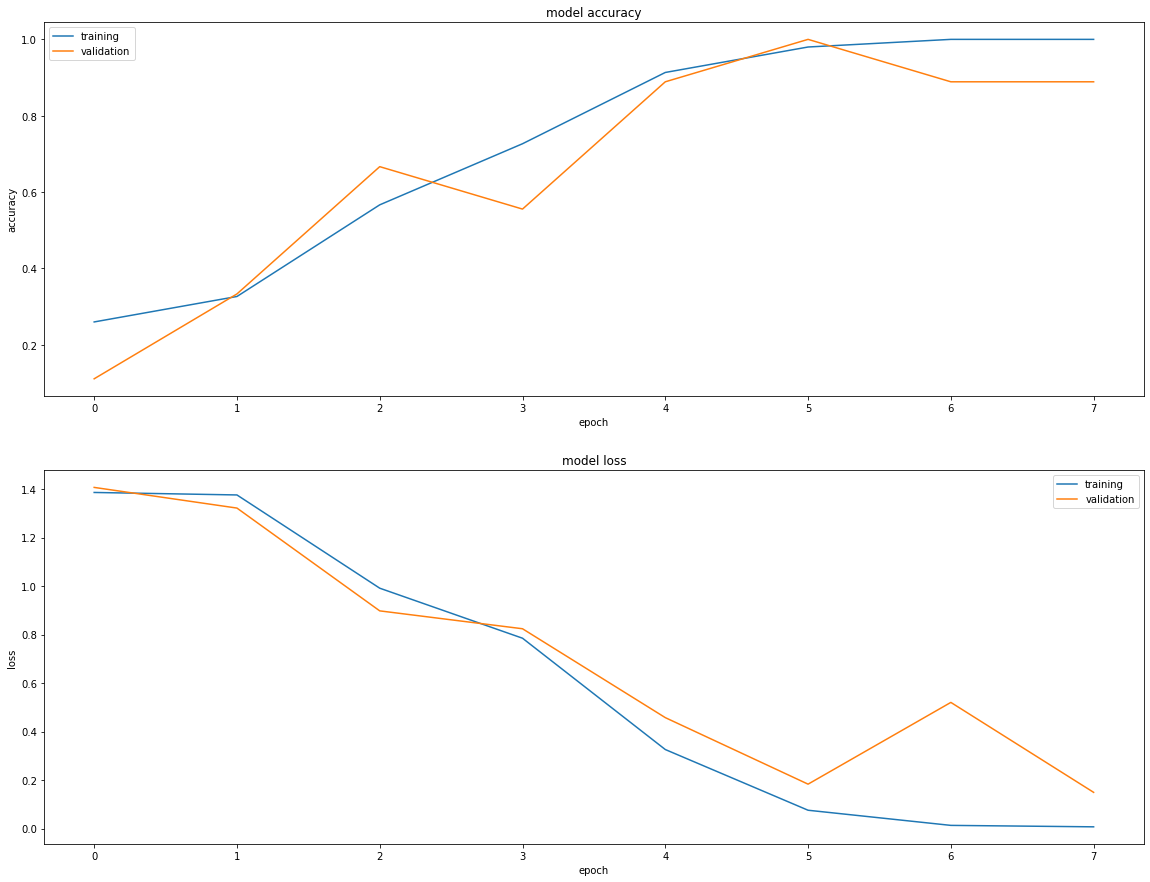

In [102]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

Assess the Model's Performance Using Confusion Matrix

In [103]:
preds2 = model.predict(test_ds)
y_pred2 = np.argmax(preds2, axis=1)
y2 = np.concatenate([y for x, y in test_ds], axis=0)

6/6 [==============================] - 4s 37ms/step


In [104]:
CLASSES_LIST = ['Action','Comedy','Horror','Sci Fi']

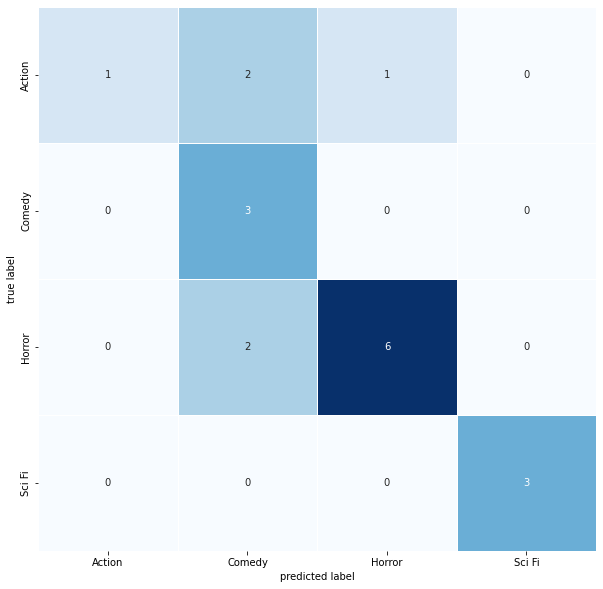

In [105]:
plot_confusion_matrix_labeled(y2,y_pred2, CLASSES_LIST=CLASSES_LIST)

In [106]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [107]:
df2 = pd.DataFrame(preds2[0:15]
                  ,columns = CLASSES_LIST).T
df2.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Action,0.17%,91.27%,0.19%,0.48%,0.03%,5.41%,0.68%,0.38%,1.79%,0.08%,0.34%,0.06%,0.50%,0.02%,0.15%
Comedy,0.18%,6.12%,0.31%,0.89%,99.43%,69.93%,7.83%,95.41%,20.99%,89.19%,0.39%,80.88%,1.96%,1.90%,0.18%
Horror,98.79%,1.35%,99.02%,92.38%,0.32%,24.26%,33.31%,0.40%,76.76%,1.68%,98.22%,1.44%,96.31%,0.43%,99.01%
Sci Fi,0.87%,1.26%,0.48%,6.25%,0.22%,0.40%,58.17%,3.80%,0.46%,9.06%,1.05%,17.61%,1.24%,97.64%,0.67%


#### 2.2.2) Genre Classification LSTM Model 2

#### 2.2.3) Genre Classification LSTM Model 3

#### 2.2.4) Genre Classification LSTM Model 4

### 2.3) Sentiment Analysis and Classification with LSTM Models

Let's now turn our attention toward creating LSTM models capable of classifying movie reviews as having either positive or negative sentiments.

#### 2.3.1) Sentiment Classification LSTM Model 1

#### 2.3.2) Sentiment Classification LSTM Model 2

#### 2.3.3) Sentiment Classification LSTM Model 3

#### Sentiment Classification LSTM Model 4